# STEP3 오늘의 날씨에 맞는 장르 추천

In [3]:
import root
import json
import copy
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gensim.downloader as api
import xml.etree.ElementTree as ET
from matplotlib import rc
from itertools import product
from joblib import dump, load
from scipy.stats import pearsonr
from datetime import datetime, timedelta
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from concurrent.futures import ThreadPoolExecutor, as_completed
from tslearn.clustering import TimeSeriesKMeans
from module import eda
from module.data_preprocess import weather_cleaner

'''--------------------------- 기초 설정 및 파일 불러오기 ---------------------------'''

%load_ext autoreload
%autoreload 2

rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False # 유니코드 마이너스 사용 X

cleaned = weather_cleaner()
country = cleaned.country
state = cleaned.state
city = cleaned.city
weather = cleaned.weather
weather_cols = cleaned.weather_cols
streams = cleaned.genre_streams_by_country

### 날씨 변수 간 상관 행렬 확인

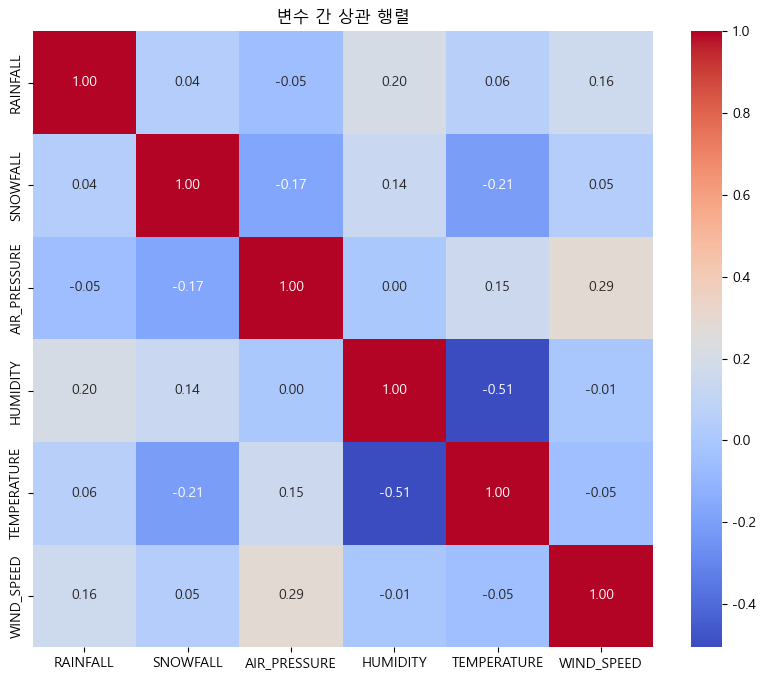

In [4]:
plt.figure(figsize=(10, 8))
sns.heatmap(weather[weather_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('변수 간 상관 행렬')
plt.show()

### 데이터 선별 작업
- 학습 시간 감소 및 불필요한 데이터 제거 목적

- 쾨펜의 기후 분류 방법 활용

In [5]:
# {'기후 분류코드': df[COUNTRY_CODE, DISTRICT, CITY, KOPPEN_CLASS, GEOMETRY, POINT, POPULATION]}
original_koppen_dfs = cleaned.koppen_dfs(weather)

selected_weather = cleaned.select_weather(original_koppen_dfs=original_koppen_dfs)
select_koppen_dfs = cleaned.koppen_dfs(selected_weather)

eda.koppen_map(koppen_df=original_koppen_dfs, city=city)

- 쾨펜 기후 분류는 추상적 기준과 일부 필요한 날씨 데이터의 부재로 인해 분류 과정이 추정에 기반해 진행됨
<br />

- 유럽 대부분 지역은 온대 기후와 대륙성 기후를 보이며, 북쪽은 대륙성 기후, 남쪽은 온대 기후가 주를 이루고, 해안가 및 일부 섬에서는 극지 기후의 특성이 관찰되기도 함
<br />

- 유럽 본토 외 지역이 유럽으로 분류됨

### 누락된 데이터 보완
- 도시 인구수 데이터 활용 전 누락된 날씨 데이터를 보완하기 위해 진행함
- KNNImputer 사용하여 데이터 결측치를 채움
- 거리가 먼 데이터를 사용할 경우 부정확한 결과가 발생할 수 있어, 유럽 본토에서 멀리 떨어진 도시를 분석 대상에서 제외함

In [6]:

''' ------------------- KNNImputer를 사용하여 누락된 값 대체 ------------------- '''
def __selected_imputed_weather(**kwargs):
        """
        :param koppen_dfs: {key: DataFrame} 쾨펜 기후 분류
        :return: 누락된 데이터를 채운 DataFrame 'DATE', 'CITY', 'TIME_GROUP', 'POINT', 'POPULATION', 날씨 특성
        """
        koppen_dfs = kwargs.get('koppen_dfs')

        select_countries = set().union(
            *(df['COUNTRY_CODE'].unique() for df in koppen_dfs.values())
        )

        dates = pd.date_range(start='2019-01-01', end='2019-12-31')

        merged = (
            country[country['COUNTRY_CODE'].isin(select_countries)]
            .merge(state, on='COUNTRY_CODE')
            .merge(city, on='DISTRICT')
        )

        tmp = pd.DataFrame(list(product(dates, range(0, 4))), columns=['DATE', 'TIME_GROUP'])

        # 선택된 국가의 모든 날씨 데이터 채우기
        all_possibility = pd.merge(merged.assign(key=1), tmp.assign(key=1), on='key', how="inner", validate="many_to_many").drop('key', axis=1)
        all_possibility = (
            all_possibility.sort_values(by=['COUNTRY_CODE', 'DATE', 'CITY', 'TIME_GROUP'])
            .drop(columns=['GEO_CODE', 'COUNTRY_NAME', 'DISTRICT', 'GEOMETRY'])
            .reset_index(drop=True)
            .merge(weather, on=['DATE', 'CITY', 'TIME_GROUP'], how='left', validate="one_to_one")
        )

        # 'POINT' 컬럼에서 x, y 값을 추출하여 새로운 컬럼에 할당
        all_possibility['LAT'] = [point.y for point in all_possibility['POINT']]
        all_possibility['LNG'] = [point.x for point in all_possibility['POINT']]

        # 용량을 줄이기 위해 데이터 타입을 'float32'로 변환
        all_possibility['LAT'] = all_possibility['LAT'].astype('float32')
        all_possibility['LNG'] = all_possibility['LNG'].astype('float32')

        separate_by_country = {k: v for k, v in all_possibility.groupby('COUNTRY_CODE')}
        
        standard_cols = ['DATE', 'TIME_GROUP', 'LAT', 'LNG']

        # 병렬 처리를 위한 함수1
        def __process_dataframe(dataframe):
            selected_ = dataframe[standard_cols + weather_cols]
            return __similar_country_imputed(df=selected_)

        with ThreadPoolExecutor(max_workers=6) as executor:
            future_to_country = {
                country_: executor.submit(__process_dataframe, df_) for country_, df_ in separate_by_country.items()
            }
            tmp = [future.result() for future in as_completed(future_to_country.values())]

        result = pd.concat(tmp) # 병렬 처리된 df 합치기
        selected = all_possibility[standard_cols + ['CITY', 'POINT', 'POPULATION']]
        result =  pd.merge(result, selected, on=standard_cols, how='left', validate="one_to_one")

        return result[['DATE', 'CITY', 'TIME_GROUP', 'POINT', 'POPULATION'] + weather_cols]

# 병렬 처리를 위한 함수2
def __similar_country_imputed(**kwargs):
    """
    :param df: [DATE,TIME_GROUP,LAT,LNG,날씨 특성] DataFrame
    :return: 누락된 데이터를 대체한 DataFrame
    """
    dataframe = copy.deepcopy(kwargs.get("df"))
    base_date_ = pd.to_datetime('2018-12-31')
    dataframe['DATE'] = (dataframe['DATE'] - base_date_).dt.days

    # 데이터 스케일링
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(dataframe)

    # KNNImputer를 사용하여 누락된 값을 대체
    imputer = KNNImputer(n_neighbors=5)
    df_imputed_scaled = imputer.fit_transform(df_scaled)

    # 스케일링된 값을 원래 범위로 되돌림
    df_imputed = scaler.inverse_transform(df_imputed_scaled)
    df_imputed = pd.DataFrame(df_imputed, columns=dataframe.columns)
    df_imputed['DATE'] = pd.to_timedelta(df_imputed['DATE'], unit='D') + base_date_

    return df_imputed

selected_imputed_weather = __selected_imputed_weather(koppen_dfs=select_koppen_dfs)
# {'기후 분류코드': df[COUNTRY_CODE, DISTRICT, CITY, KOPPEN_CLASS, GEOMETRY, POINT, POPULATION]}
select_koppen_dfs = cleaned.koppen_dfs(selected_imputed_weather)
eda.koppen_map(koppen_df=select_koppen_dfs, city=city)

### 시계열 클러스터링을 통한 날씨 패턴 라벨링
- 시간에 따른 날씨 변화가 음악 선택에 영향을 미친다는 가정하에 시계열 클러스터링을 사용하여 라벨링
- 적절한 클러스터 개수 선정의 어려움으로 인해, 임의로 클러스터 개수를 정하여 클러스터링 수행함

In [7]:
''' ------------------- 날씨 특성 정규화 ------------------- '''
def __scaler_model(**kwargs): # 실행 파일 저장 필요
    """
    :param df: 날씨 DataFrame
    :return: 스케일링 된 DataFrame
    """
    df = kwargs.get("df")
    data_to_scale = df[weather_cols]
    scaler = StandardScaler().fit(data_to_scale)
    scaled_data = scaler.transform(data_to_scale)
    df.loc[:, weather_cols] = scaled_data
    dump(scaler, root.get_path('scaler'))
    return df

''' ------------------- 날씨 패턴 클러스터링 ------------------- '''
def __time_cluster():
    """    
    :return: 상관관계 분석을 위한 Dataframe
    """
    standard_cols = ['DATE', 'CITY', 'TIME_GROUP']
    
    time_weather = selected_imputed_weather[standard_cols + weather_cols]
    time_weather = __scaler_model(df=time_weather)    

    grouped = time_weather.groupby(['DATE', 'CITY'])

    # 시계열 데이터 리스트
    timeseries_list = []
    # 각 그룹의 인덱스 정보를 저장할 리스트 (DATE, CITY)
    index_list = []

    for name, group in grouped:
        timeseries_data = group.sort_values('TIME_GROUP').drop(standard_cols, axis=1).to_numpy()
        timeseries_list.append(timeseries_data)
        index_list.append(name)

    timeseries_array = np.array(timeseries_list)

    # 클러스터링 수행
    model = TimeSeriesKMeans(n_clusters=36, metric="euclidean", max_iter=10, random_state=0)
    labels = model.fit_predict(timeseries_array)

    # 클러스터 레이블을 DATE, CITY와 함께 데이터프레임으로 변환
    cluster_results = pd.DataFrame(index_list, columns=['DATE', 'CITY'])
    cluster_results['CLUSTER'] = labels

    cluster_results = (
        cluster_results.merge(city, on='CITY', how="inner", validate="many_to_one")
        .merge(state, on='DISTRICT', how="inner", validate="many_to_many")        
    )
    cluster_results = cluster_results[['DATE', 'COUNTRY_CODE', 'CLUSTER', 'POPULATION']]

    min_max_scaler = MinMaxScaler()
    cluster_results['POPULATION'] = min_max_scaler.fit_transform(cluster_results['POPULATION'].values.reshape(-1, 1))
    cluster_results = cluster_results.pivot_table(
        index=['DATE', 'COUNTRY_CODE'], columns='CLUSTER', values='POPULATION', aggfunc='sum', fill_value=0
    )
    cluster_results = cluster_results.reset_index()

    genre_streams = streams.groupby(['DATE', 'COUNTRY_CODE', 'GENRE'], as_index=False).mean()
    cluster_results = cluster_results.merge(genre_streams, on=['DATE', 'COUNTRY_CODE'], how='inner')

    dump(model, root.get_path('time_model'))

    return cluster_results # 클러스터 결과 dataframe

selected_time_cluster = __time_cluster()
selected_time_cluster.head()

,DATE,COUNTRY_CODE,0,1,2,3,4,5,6,7,...,28,29,30,31,32,33,34,35,GENRE,STREAMS
0,2019-01-02,ESP,0.0,0.0,0.0,0.0,0.248536,0.0,0.000000,0.115817,...,0.0,0.000000,2.317350,0.0,0.848235,0.0,0.0,0.086658,latin,38537.000000
1,2019-01-02,ESP,0.0,0.0,0.0,0.0,0.248536,0.0,0.000000,0.115817,...,0.0,0.000000,2.317350,0.0,0.848235,0.0,0.0,0.086658,pop,44450.428571
2,2019-01-02,ESP,0.0,0.0,0.0,0.0,0.248536,0.0,0.000000,0.115817,...,0.0,0.000000,2.317350,0.0,0.848235,0.0,0.0,0.086658,r&b,59376.200000
3,2019-01-02,ESP,0.0,0.0,0.0,0.0,0.248536,0.0,0.000000,0.115817,...,0.0,0.000000,2.317350,0.0,0.848235,0.0,0.0,0.086658,rap,48584.750000
4,2019-01-02,GRC,0.0,0.0,0.0,0.0,0.100613,0.0,0.007549,0.000000,...,0.0,0.057995,0.034215,0.0,0.008580,0.0,0.0,0.000000,pop,1229.000000


### 각 국가별 장르 선호도 가중치 계산
- Glove 모델을 사용하여 장르와 각 국가별 상위 100개의 음악 태그 간 단어 유사도를 사용해 각 국가별 장르 선호도에 대한 가중치를 구하고자 함
- 장르와 연관성이 낮은 단어들이 국가별 음악 선호도 분석 결과에 부정적인 영향을 미칠 수 있다는 생각이 들어 e 지수 함수를 활용하여 가중치를 조정함

In [8]:
''' ------------------- 국가별 장르 선호 가중치 ------------------- '''
def __preference_analyze():
    """
    :return: 국가별 장르 선호 가중치 DataFrame 
    """
    # GloVe 모델 다운로드 & 로딩 대략 몇 분 걸립니다.
    model = api.load("glove-twitter-200")

    preference_genre_tag = pd.read_csv(root.get_path('last_fm'))

    genre_list = streams['GENRE'].unique()
    results = []

    for genre in genre_list:
        for tag in preference_genre_tag['TAG'].unique():
            similarity = -1  # 초기 유사도 설정
            token = tag.split()  # 태그를 공백 기준으로 분리
            for t in token:
                try:
                    val = model.similarity(genre, t)  # 유사도 계산
                    if val > similarity:
                        similarity = val  # 최대 유사도 업데이트
                except KeyError:
                    continue  # 모델에 단어가 없는 경우 계속 진행
            if similarity > -1:
                # 유효한 유사도가 있는 경우 결과 리스트에 추가
                results.append({
                    'TAG': tag,
                    'GENRE': genre,
                    'WEIGHT': np.exp(similarity)  # e^similarity로 가중치 계산
                })

    preference_df_ = pd.DataFrame(results)
    preference_df_ = (
        preference_df_.merge(preference_genre_tag, on='TAG', how='inner')
        .merge(country, on='COUNTRY_NAME', how='outer')
    )
    preference_df_ = preference_df_[['COUNTRY_NAME', 'COUNTRY_CODE', 'GENRE', 'WEIGHT']]
    preference_df_.loc[preference_df_['COUNTRY_NAME'] == 'Korea, Republic of', 'COUNTRY_CODE'] = 'KOR'

    return preference_df_.groupby(['COUNTRY_NAME', 'COUNTRY_CODE', 'GENRE'], as_index=False).mean()

preference_df = __preference_analyze()
preference_df.head()

,COUNTRY_NAME,COUNTRY_CODE,GENRE,WEIGHT
0,Austria,AUT,edm,1.438444
1,Austria,AUT,latin,1.379942
2,Austria,AUT,pop,1.623706
3,Austria,AUT,r&b,1.426240
4,Austria,AUT,rap,1.585891


### 국가별 장르 청취수에 장르 선호도 가중치 반영

In [9]:
''' ------------------- 청취수/유럽 국가 가중치 * 한국 가중치 ------------------- '''
def __korea_optimized_genre(**kwargs):
    """
    :param preference_df_: 국가별 장르 선호 가중치 DataFrame
    :return: pivot 된 날씨 패턴 + 스트리밍 DataFrame
    """
    preference_df_ = kwargs.get("preference_df_")
    time_cluster_ = kwargs.get("time_cluster")

    def optimize(row):
        euro_condition = (preference_df_['COUNTRY_CODE'] == row['COUNTRY_CODE']) &\
                            (preference_df_['GENRE'] == row['GENRE'])
                
        kor_condition = (preference_df_['COUNTRY_CODE'] == 'KOR') &\
                            (preference_df_['GENRE'] == row['GENRE'])
        
        euro_weight = preference_df_[euro_condition]['WEIGHT'].values
        kor_weight = preference_df_[kor_condition]['WEIGHT'].values
        
        if len(euro_weight) > 0:
            row['STREAMS'] = row['STREAMS'] / euro_weight[0] * kor_weight[0]            
        return row

    time_cluster_ = time_cluster_.apply(optimize, axis=1)
    return time_cluster_

time_cluster = __korea_optimized_genre(preference_df_=preference_df, time_cluster=selected_time_cluster)
time_cluster.head()

,DATE,COUNTRY_CODE,0,1,2,3,4,5,6,7,...,28,29,30,31,32,33,34,35,GENRE,STREAMS
0,2019-01-02,ESP,0.0,0.0,0.0,0.0,0.248536,0.0,0.000000,0.115817,...,0.0,0.000000,2.317350,0.0,0.848235,0.0,0.0,0.086658,latin,40062.279627
1,2019-01-02,ESP,0.0,0.0,0.0,0.0,0.248536,0.0,0.000000,0.115817,...,0.0,0.000000,2.317350,0.0,0.848235,0.0,0.0,0.086658,pop,45957.000579
2,2019-01-02,ESP,0.0,0.0,0.0,0.0,0.248536,0.0,0.000000,0.115817,...,0.0,0.000000,2.317350,0.0,0.848235,0.0,0.0,0.086658,r&b,61441.427290
3,2019-01-02,ESP,0.0,0.0,0.0,0.0,0.248536,0.0,0.000000,0.115817,...,0.0,0.000000,2.317350,0.0,0.848235,0.0,0.0,0.086658,rap,50946.340668
4,2019-01-02,GRC,0.0,0.0,0.0,0.0,0.100613,0.0,0.007549,0.000000,...,0.0,0.057995,0.034215,0.0,0.008580,0.0,0.0,0.000000,pop,1324.493447


### 각 날씨 패턴에 따라 가장 상관계수가 높은 음악 장르를 추출 


In [10]:
''' ------------------- 상관계수가 가장 높은 장르 ------------------- '''
def corr(**kwargs):
    """
    :param time_cluster: pivot 된 날씨 패턴 + 스트리밍 DataFrame
    :return: 날씨패턴, 상관계수가 가장 높은 장르 DataFrame
    """    
    time_cluster_ = kwargs.get("time_cluster")
    exclude_cols = ['DATE', 'COUNTRY_CODE', 'GENRE', 'STREAMS']
    weather_pattern_cols = [col for col in time_cluster_.columns if col not in exclude_cols]

    correlation_results = pd.DataFrame()

    group = time_cluster_[['GENRE', 'STREAMS'] + weather_pattern_cols]
    group = group.groupby('GENRE')

    for genre, weather_pattern_df in group:
        for pattern in weather_pattern_cols:
            selected_df = copy.deepcopy(weather_pattern_df[pattern])
            selected_df = selected_df.drop_duplicates()
            if selected_df.size == 1:
                continue
            corr, _ = pearsonr(weather_pattern_df[pattern], weather_pattern_df['STREAMS'])
            dataframe = pd.DataFrame({
                'WEATHER_PATTERN': [pattern],
                'GENRE': [genre],
                'CORR': [corr]
            })
            correlation_results = pd.concat([correlation_results, dataframe])

    sorted_correlation_results = correlation_results.sort_values(by=['WEATHER_PATTERN', 'CORR'], ascending=[True, False])
    return sorted_correlation_results.drop_duplicates(subset=['WEATHER_PATTERN'])

recommend = corr(time_cluster=time_cluster)[['WEATHER_PATTERN', 'GENRE']]
recommend.to_csv(root.get_path('recommend'), index=False)
recommend.head()

,WEATHER_PATTERN,GENRE
0,0,latin
0,1,latin
0,2,edm
0,3,rap
0,4,rock


### 날씨 API와 연동하여 오늘의 추천 장르 출력
- 기압에 대한 예보 데이터가 없어, 하루 전 실제 기압 데이터 사용

In [11]:
with open(root.get_path('config'), 'r') as config_file:
    config = json.load(config_file)
    
api_key = config['weather_key']

''' ------------------- 기본 날씨 데이터 오늘 예보 [온도, 상대습도 등] ------------------- '''
url = "http://apis.data.go.kr/1360000/VilageFcstInfoService_2.0/getVilageFcst"

today = datetime.now().strftime("%Y%m%d")
base_date = (datetime.now() - timedelta(days=1)).strftime("%Y%m%d")  # 전날 날짜
base_time = "2300"

# 격자 좌표 설정 (서울시청 기준)
nx = "60"
ny = "127"

# 요청 파라미터 설정
params = {
    "serviceKey": api_key,
    "numOfRows": "300",  # 충분히 큰 값으로 설정하여 하루 전체 데이터를 받음
    "dataType": "JSON",
    "base_date": base_date,
    "base_time": base_time,
    "nx": nx,
    "ny": ny,
}

forcast_dict = {}

# API 요청
response = requests.get(url, params=params)

# 응답 데이터 처리
if response.status_code == 200:
    data = response.json()
    forecasts = data.get("response", {}).get("body", {}).get("items", {}).get("item", [])
    for forecast in forecasts:
        fcstDate = forecast.get("fcstDate")  # 예보 날짜 (YYYYMMDD)
        fcstTime = forecast.get("fcstTime")  # 예보 시간 (HHMM)
        fcstValue = forecast.get("fcstValue")  # 예보 값
        category = forecast.get("category")  # 예보 항목 (온도, 하늘 상태, 강수 확률 등)
        if fcstDate == today:
            forcast_dict.setdefault(fcstTime, []).append({category: fcstValue})
else:
    print("Error:", response.status_code)
    
rows = []
for time, category_list in forcast_dict.items():
    row = {'time': time}
    for category in category_list:
        row.update(category)
    rows.append(row)

df = pd.DataFrame(rows)

df = df.rename(columns={
    'time': 'TIME',
    'TMP': 'TEMPERATURE',
    'WSD': 'WIND_SPEED',
    'REH': 'HUMIDITY',
    'PCP': 'RAINFALL',
    'SNO': 'SNOWFALL'
})

df = df.applymap(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0)

df['TIME'] = (df['TIME']/100).astype(int)

bins = [-1, 6, 12, 18, 24]
labels = range(4)
df['TIME_GROUP'] = pd.cut(df['TIME'], bins=bins, labels=labels, right=True)
df.drop(columns=['TIME'], inplace=True)
df = df.groupby('TIME_GROUP').mean()

''' ------------------- 어제 기압 평균 (기압은 예보로 구할 수 없었음) ------------------- '''

base_url = "http://apis.data.go.kr/1360000/AsosHourlyInfoService/getWthrDataList"
seoul = "108"  # 서울 지역 코드

# API 요청을 위한 파라미터 설정
params = {
    "serviceKey": api_key,
    "numOfRows": "10",
    "pageNo": "1",
    "dataCd": "ASOS",
    "dateCd": "HR",
    "startDt": base_date,
    "startHh": "00",
    "endDt": base_date,
    "endHh": "23",
    "stnIds": seoul,
    "_type": "XML"
}

# API 요청
response = requests.get(base_url, params=params)
avg_pa = 0

# 응답 데이터 확인
if response.status_code == 200:
    # XML 응답 파싱
    parse = ET.fromstring(response.content)
    total_pa = 0
    count = 0
    
    # 'item' 태그를 찾고 기압('pa') 데이터 추출
    for item in parse.iter('item'):
        pa = float(item.find('pa').text) * 100 # 단위 hPa -> Pa
        total_pa += pa
        count += 1
    avg_pa = total_pa/count
else:
    print("API 요청에 실패했습니다. 상태 코드:", response.status_code)
    
df['AIR_PRESSURE'] = 99000 if avg_pa==0 else avg_pa

''' ------------------- 학습된 모델을 불러와 장르 추천 ------------------- '''

weather_cols = ['RAINFALL', 'SNOWFALL', 'AIR_PRESSURE', 'HUMIDITY', 'TEMPERATURE', 'WIND_SPEED']
scale = load(root.get_path('scaler'))
scaled_data = scale.transform(df[weather_cols])

scaled_data_reshaped = scaled_data.reshape(1, scaled_data.shape[0], scaled_data.shape[1])
time_model = load(root.get_path('time_model'))
weather_pattern = time_model.predict(scaled_data_reshaped)[0]

recommend = pd.read_csv(root.get_path('recommend'))
genre = recommend.loc[recommend['WEATHER_PATTERN']==weather_pattern, 'GENRE'].iloc[0]
print(f'오늘의 추천 장르: {genre}')

오늘의 추천 장르: rock
